In [99]:
import numpy as np
import pylab as plt
from scipy.stats import beta
from scipy.special import gammaln
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


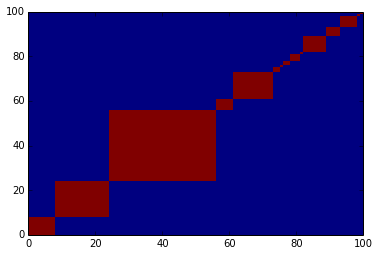

In [112]:
from peak_clusterer import hyper,data_generator
h = hyper()
dg = data_generator(h,n_peaks = 100,seed=1)
dg._make_data()
true_Z = dg.Z
true_post = (true_Z == true_Z[:,np.newaxis])
plt.figure()
plt.pcolor(true_post)

12


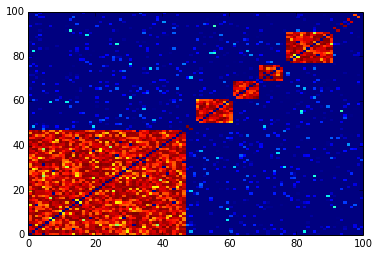

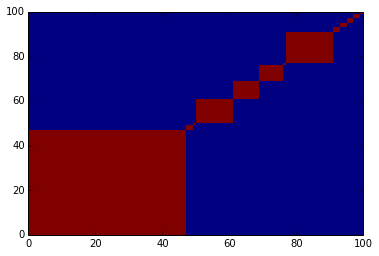

In [44]:
from peak_clusterer import hyper
h = hyper()
N = 100
Z = []
counts = []
Z.append(1)
counts.append(1)
for n in np.arange(1,N):
#     List concatanation
    temp = np.array(counts + [h.conc_par])
    temp = temp/temp.sum()
    prob = temp.cumsum()
    pos = np.nonzero(np.random.rand()<prob)[0][0]
    Z.append(pos)
    if pos >= len(counts):
        counts.append(1)
    else:
        counts[pos] = counts[pos] + 1

Z = np.sort(Z)

true_K = np.max(Z)
true_Z = Z
X = np.zeros((N,N))
for n in np.arange(N-1):
    this_cluster = Z[n]
    for m in np.arange(n+1,N):
        if Z[m] == this_cluster:
            if np.random.rand() < h.in_prob:
                this_val = beta.rvs(h.in_alpha,h.in_beta)
            else:
                this_val = 0
        else:
            if np.random.rand() < h.out_prob:
                this_val = beta.rvs(h.out_alpha,h.out_beta)
            else:
                this_val = 0
        
        X[n,m] = this_val
        X[m,n] = this_val

plt.pcolor(X)
print true_K
true_post = (Z == Z[:,np.newaxis])
plt.figure()
plt.pcolor(true_post)

Creating likelihood matrices
Sample 0
Sample 10
Sample 20
Sample 30
Sample 40
Sample 50
Sample 60
Sample 70
Sample 80
Sample 90


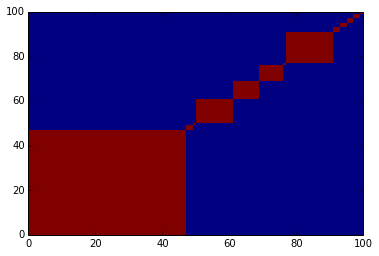

In [83]:
from peak_clusterer import shape_cluster_gibbs
pc = shape_cluster_gibbs(X,h,infinite=False,track=True,output=1)
pc._initialise_clustering()
pc._sample()
plt.pcolor(pc.post_sim)

In [57]:
in_like = np.zeros((N,N))
out_like = np.zeros((N,N))

0 30
10 30
20 30
30 30
40 30
50 30
60 30
70 30
80 30
90 30


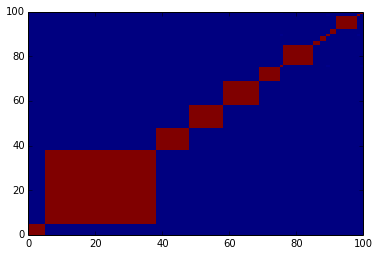

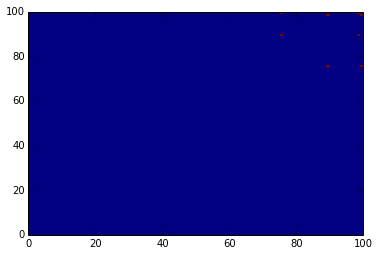

In [53]:
n_samps = 100
# Z = np.arange(0,N)
# K = N
# counts = np.ones_like(Z).tolist()
post_sim = np.zeros((N,N),dtype=np.float64)



infinite = False
track = True

# Track makes things more efficient by keeping track of cluster likelihoods. It currently won't work for infinite mixtures (it would be very slow for these anyway)

base_like = out_like.sum(axis=0)

if infinite:
    Z = np.zeros(N,dtype=np.int64)
    counts = [N]
    K = 1
else:
    K = 30
    Z = np.zeros(N,dtype=np.int64)
    counts = np.zeros(K).tolist()
    counts[0] = N
    
if track:
    temp = np.tile(out_like.sum(axis=1),(K,1))
    temp[0,:] = in_like.sum(axis=1)



for samp in np.arange(n_samps):
    if samp%10 == 0:
        print samp,K
    for peak in np.arange(N):
        this_peak = peak
        this_cluster = Z[this_peak]
        Z[this_peak] = -1
        counts[this_cluster]-=1       
        
        if track:
            temp -= out_like[this_peak,:]
            temp[this_cluster,:]+=out_like[this_peak,:]-in_like[this_peak,:]
        
        if counts[this_cluster] == 0 and infinite:
            K -= 1
            counts.pop(this_cluster)
            Z[np.where(Z>this_cluster)]-=1
        
        if infinite:
            prior = np.log(np.hstack((counts,h.conc_par)))
        else:
            prior = np.log([c + h.conc_par/K for c in counts])
        
        
        if not track:
            print 'boo'
            like = np.zeros_like(prior)
            for k in np.arange(K):
                in_pos = np.where(Z==k)[0]
                like[k] = base_like[this_peak] - out_like[this_peak,in_pos].sum()
                like[k] += in_like[this_peak,in_pos].sum()
            if infinite:
                like[-1] = out_like[this_peak].sum()
        else:
            like = temp[:,this_peak]
        
        post = prior + like
        post = np.exp(post - np.max(post))
        post = post/post.sum()
        new_cluster = np.where(np.random.rand()<post.cumsum())[0][0]
        if new_cluster >= K:
            Z[this_peak]=K
            counts.append(1)
            K += 1
        else:
            Z[this_peak] = new_cluster
            counts[new_cluster]+=1
            if track:
                temp += out_like[this_peak,:]
                temp[new_cluster,:] += in_like[this_peak,:]-out_like[this_peak,:]
        
    for k in np.arange(K):
        pos = np.where(Z==k)[0]
        post_sim[pos[:,np.newaxis],pos] += 1

post_sim /= n_samps
plt.pcolor(post_sim)
plt.figure()
plt.pcolor(np.abs(post_sim-true_post))